In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import sys
sys.settrace
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pylab import *
import struct
import array
import os
import glob
import h5py
from scipy.interpolate import griddata
from scipy import integrate
from scipy import special

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif",
#    "font.serif": ["Palatino"],
#})

plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
plt.rcParams['font.size'] = '20'

from importlib import reload

/var/folders/2n/ftypqy6s65s2j7krblnn49cw0000gq/T/ipykernel_94719/2225137914.py:30: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']


In [2]:
import athena_read

In [3]:
#This is the integral of blackbody from 0 to nu_t (h\nu/kT)
def FitBlackBody(nu_t):
    integral = 0.0;
    nu_2 = nu_t * nu_t;
    nu_3 = nu_t * nu_2;
    nu_7 = nu_2 * nu_2 * nu_3
    if nu_t < 1.8:
        integral = 0.051329911273422 * nu_3 -0.019248716727533 * nu_t * nu_3 + 0.002566495563671 * nu_2 * nu_3
        -3.055351861513195*1.e-5*nu_7
    elif nu_t < 18.6:
        exp_nu = exp(-nu_t);
        integral = -0.156915538762850 * exp_nu * (nu_3 + 2.69 * nu_2 + 6.714 * nu_t) + 1.000009331428801*(1- exp_nu);
    else:
        integral = 1.0 - 192.1*exp(-0.9014*nu_t)

    return integral;
#This is the blackbody spectrum for each frequency nu_t (h\nu/kT)
def BlackBody(nu, tr):
    nu_t=nu/tr
    exp_1=exp(nu_t)-1
    if nu_t < 1.e-5:
      exp_1=tr**3.0*nu_t**2.0
    else:
      exp_1=nu**3.0/exp_1

    spec=(15/np.pi**4.0)*exp_1

    return spec;

In [46]:
def PlotProfile(datax, datay, xmin, xmax, ymin, ymax,  ylabel, label1, filename, xlabel='$r/r_g$', logscale=0, 
                xlogscale=0,datay1_2=None, datay1_3=None, datax2=None, datay2=None, datay2_2=None, datay2_3=None, 
                datax3=None, datay3=None, datay3_2=None, datay3_3=None, datax4=None, datay4=None, 
                datax5=None, datay5=None, label2='', label3='', label4='', label5='',title=None,leg_loc=None):
    plots, axes = plt.subplots(figsize=(9,9),dpi=300)
    plt.xlabel(xlabel, size = 30)
    plt.ylabel(ylabel, size = 30)
    plt.subplots_adjust(left=0.16,right=0.88,top=0.9,bottom=0.1)
    plt.ylim([ymin,ymax])
    plt.xlim([xmin,xmax])
    if logscale > 0:
      axes.set_yscale('log')
    if xlogscale > 0:
      axes.set_xscale('log')
    if title is not None:
      plt.title(title,size=20)

    plt.plot(datax,datay,color='black',linestyle='solid',label=label1,linewidth=3.0,marker='o',mfc='None',ms=10)
#    plt.plot(datax,datay,color='black',linestyle='dashed',label=label1,linewidth=3.0)
    if datay1_2 is not None:
      plt.scatter(datax,datay1_2,marker='o',s=60,facecolors='none', edgecolors='red')
    if datay1_3 is not None:
      plt.plot(datax,datay1_3,color='black',linestyle='dashed',linewidth=4.0)
    if datay2 is not None:
      plt.scatter(datax2,datay2,color='red',marker='o',s=60,facecolors='none',edgecolors='red',
                  label=label2,alpha=1.0,linewidth=3.0)
    if datay2_2 is not None:
      plt.plot(datax2,datay2_2,color='black',linestyle='dashed',linewidth=2.0,alpha=1.0)
    if datay2_3 is not None:
      plt.plot(datax2,datay2_3,color='red',linestyle='dashed',linewidth=4.0)
    if datay3 is not None:
      plt.plot(datax3,datay3,color='green',label=label3,linewidth=3.0)
    if datay3_2 is not None:
      plt.plot(datax3,datay3_2,color='black',linestyle='dashed',linewidth=2.0,alpha=1.0)
    if datay3_3 is not None:
      plt.plot(datax3,datay3_3,color='green',linestyle='dashed',linewidth=4.0)
    if datay4 is not None:
      plt.plot(datax4,datay4,color='blue',label=label4,linewidth=3.0)
    if datay5 is not None:
      plt.plot(datax5,datay5,color=tableau20[0],label=label5,linewidth=2.0) 
    if leg_loc is not None:
      plt.legend(loc="best",bbox_to_anchor=leg_loc,frameon=False)
    axes.set_aspect('auto')
#    axes.yaxis.set_tick_params(labelsize=25)
#    axes.xaxis.set_tick_params(labelsize=25)
    plt.savefig(filename)
    plt.close(plots)


In [5]:
files=sorted(glob.glob('Data/thermal.out4.*athdf'))
num_file=len(files)

In [6]:
#for filename in files:
ang_file = open('Data/Rad_angles.txt', 'r')
Lines = ang_file.readlines()
angle_line = [ line for line in Lines if  "nu_max" in line]
angle_line=angle_line[0]
crat_line = [ line for line in Lines if  "Crat" in line]
crat_line=crat_line[0]
Crat_split=crat_line.split(" ")
Crat=float(Crat_split[size(Crat_split)-2])
angle_index=Lines.index(angle_line)+1
location=Lines.index('fre   spec\n')
tot_line=size(Lines)
nfreq=tot_line-location-1
nu_grid=np.zeros(nfreq)
histories=np.zeros((num_file,52))
for i in range(nfreq):
    line=Lines[i+location+1].split(' ')[0]
    nu_grid[i]=float(line)

nu_center=np.zeros(nfreq)
nu_center[:-1]=(nu_grid[:-1]+nu_grid[1:])/2
nu_center[nfreq-1]=nu_grid[nfreq-1]
nu_width=np.zeros(nfreq-1)
nu_width=nu_grid[1:]-nu_grid[:-1]
#nu_center=np.append(nu_center,nu_grid[nfreq-1])
nang=location-angle_index
mu_x=np.zeros(nang)
mu_y=np.zeros(nang)
mu_z=np.zeros(nang)
weight=np.zeros(nang)
for n in range(nang):
    line=Lines[n+angle_index].split('   ')
    mu_x[n]=float(line[1])
    mu_y[n]=float(line[2])
    mu_z[n]=float(line[3])
    weight[n]=float(line[4].rstrip())

In [7]:
Prat=0
#Crat=8.0534e4
count=0
#filename=files[num_file-1]
filename=files[num_file-1]
print(filename)
with h5py.File(filename, 'r') as f:
  attributes = f.attrs.items()
  attrs = dict(attributes)
  level = f.attrs['MaxLevel']
  time_data = f.attrs['Time']
  subsample = False

data = athena_read.athdf(filename, level=level, subsample=subsample)
print(time_data)

Data/thermal.out4.00001.athdf
5.2116e-05


In [8]:
x1v=data['x1v']
dx=x1v[1]-x1v[0]
Er_spec=np.zeros(nfreq)
Fr_spec=np.zeros(nfreq)
Er_i_spec=np.zeros(nfreq)
Fr_i_spec=np.zeros(nfreq)



meshsize=data['RootGridSize']
nx=meshsize[0]
ny=meshsize[1]

Er_profile=np.zeros((nfreq,nx))
sigma_spe=np.zeros(nfreq)
Er_sum=np.zeros(nx)


select_index=np.argmin(np.abs(x1v-0.04))

for i in range(nfreq):
    varname='Er_'+str(i)
    Er_spec[i]=data[varname][0,0,select_index]
    Er_i_spec[i]=data[varname][0,0,0]
    Er_profile[i,:]=data[varname][0,0,:]
    varname='Fr_'+str(i)+'_1'
    Fr_spec[i]=data[varname][0,0,select_index]
    Fr_i_spec[i]=data[varname][0,0,0]  
    Er_sum=Er_sum+Er_profile[i,:]
    varname='Sigma_a_'+str(i)
    sigma_spe[i]=data[varname][0,0,select_index]
#divide frequeny bin width to get monochromatic value
for i in range(nfreq-1):
    Er_spec[i]=Er_spec[i]/nu_width[i]
    
Er_spec=Er_spec[:-1]

nu_plot=nu_center[:-1]


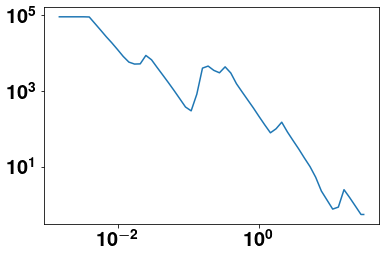

In [9]:
plt.cla()
#plt.loglog(x1v,Er_sum)
plt.loglog(nu_center,sigma_spe)

(1e-10, 0.0001)

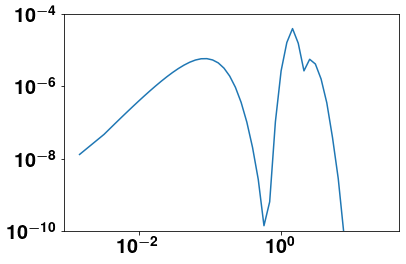

In [15]:
plt.loglog(nu_plot,Er_spec) 
plt.ylim((1.e-10,1.e-4))


In [36]:
###analytical solution
t_lbd=0.3
t_rbd=0.03
r_in=0.02
dis=x1v[select_index]
def int_fun(u):
    return np.exp(-u)/u
def solution(d,ct,nu_n):
    nu=nu_center[nu_n]
    bd_tl=BlackBody(nu,t_lbd)
    bd_tr=BlackBody(nu,t_rbd)
    sigma_nu=sigma_spe[nu_n]
    dist=d-r_in
    dist2=(d**2.0-r_in**2.0)**0.5
    tau_rin=sigma_nu*r_in
    tau_ct=sigma_nu*ct
    tau_d=sigma_nu*dist
    tau_d2=sigma_nu*dist2
    factor=0
    if (ct>d-r_in) and (ct < (d**2.0-r_in**2.0)**0.5):
        part1=(1+d/r_in-1/tau_rin)*np.exp(-tau_d)
        part2=(1/tau_rin-(r_in/ct)*(r**2/r_in**2-1))*np.exp(-tau_ct)
        part3=tau_rin*(r**2.0/r_in**2.0-1)*(integrate.quad(int_fun,tau_d,tau_ct)[0])
        factor=(r_in*0.25/d)*(part1+part2-part3)
    elif (ct > (d**2.0-r_in**2.0)**0.5):
        part1=(1+d/r_in-1/tau_rin)*np.exp(-tau_d)
        part2=(1/tau_rin-(d**2.0/r_in**2.0-1)**0.5)*np.exp(-tau_d2)
        part3=tau_rin*(d**2.0/r_in**2.0-1)*(integrate.quad(int_fun,tau_d,tau_d2)[0])
        factor=(r_in*0.25/d)*(part1+part2-part3)
    return (bd_tr+(bd_tl-bd_tr)*factor)
ana_sol=np.zeros(nfreq)
bd_lowt=np.zeros(nfreq)
ct=Crat*time_data

print(ct,dis-r_in,(dis**2.0-r_in**2.0)**0.5)
for n in range(nfreq):
    ana_sol[n]=solution(dis,ct,n) 
    bd_lowt[n]=BlackBody(nu_center[n],t_rbd)
    
    

0.042005496005003806 0.02015989601612091 0.03482552581118689


/var/folders/2n/ftypqy6s65s2j7krblnn49cw0000gq/T/ipykernel_94719/477239501.py:20: RuntimeWarning: overflow encountered in exp
  exp_1=exp(nu_t)-1


In [43]:
ct

0.042005496005003806

(1e-10, 0.01)

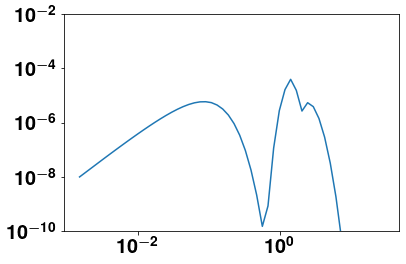

In [23]:
plt.loglog(nu_center,ana_sol)
plt.ylim((1.e-10,1.e-2))

In [45]:
ylabel='${E_r(\\tilde{\\nu})}$'
filename='spectrum_spherical.pdf'
xlabel='$\\tilde{\\nu}$'
label1='${\\rm Analytical}$'
label2='${\\rm Numerical}$'

#print(histories[:,0])
PlotProfile(nu_center,ana_sol,1.e-3, 1.e1, 1.e-10,1.e-4, ylabel, label1, filename, xlabel, logscale=1,xlogscale=1,
           datax2=nu_plot,datay2=Er_spec,label2=label2,leg_loc=(0.4,0.95))


In [47]:
ylabel='${\\rho\\kappa_a(\\tilde{\\nu})}$'
filename='radiating_opacity.pdf'
xlabel='$\\tilde{\\nu}$'


#print(histories[:,0])
PlotProfile(nu_center,sigma_spe,1.e-3, 4.e1, 4.e-1,1.1e5, ylabel, None, filename, xlabel, logscale=1,xlogscale=1)

In [73]:
ylabel='$\\rm T_r(\\nu)$'
filename='radial_profile.pdf'
xlabel='$x$'

#print(histories[:,0])
PlotProfile(x1v,Er_profile[0,:]**0.25,0, 1, 1.e-5, 1, ylabel, None, filename, xlabel, logscale=1,xlogscale=0,
            datax2=x1v,datay2=Er_profile[5,:]**0.25,datax3=x1v,datay3=Er_profile[10,:]**0.25,
            datax4=x1v,datay4=Er_profile[12,:]**0.25)

In [93]:
ylabel='$\\rm T_r(\\nu)$'
filename='tau_radial_profile.pdf'
xlabel='$x$'

#print(histories[:,0])
PlotProfile(x1v,tau_profile[0,:],0, 1, 1.e-6, 30, ylabel, None, filename, xlabel, logscale=1,xlogscale=0,
            datay1_2=tau_profile[5,:],datax3=x1v,datay3=tau_profile[10,:],
            datax4=x1v,datay4=tau_profile[12,:])